In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding to handle varying lighting
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2)
    
    # Apply morphological operations to enhance suture lines
    kernel = np.ones((3, 3), np.uint8)
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Find the region of interest (the practice pad)
    contours, _ = cv2.findContours(
        morphed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour is the practice pad
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [largest_contour], 0, 255, -1)
        
        # Apply the mask to focus only on the pad area
        roi = cv2.bitwise_and(morphed, mask)
        return roi, mask
    
    return morphed, np.ones_like(gray) * 255

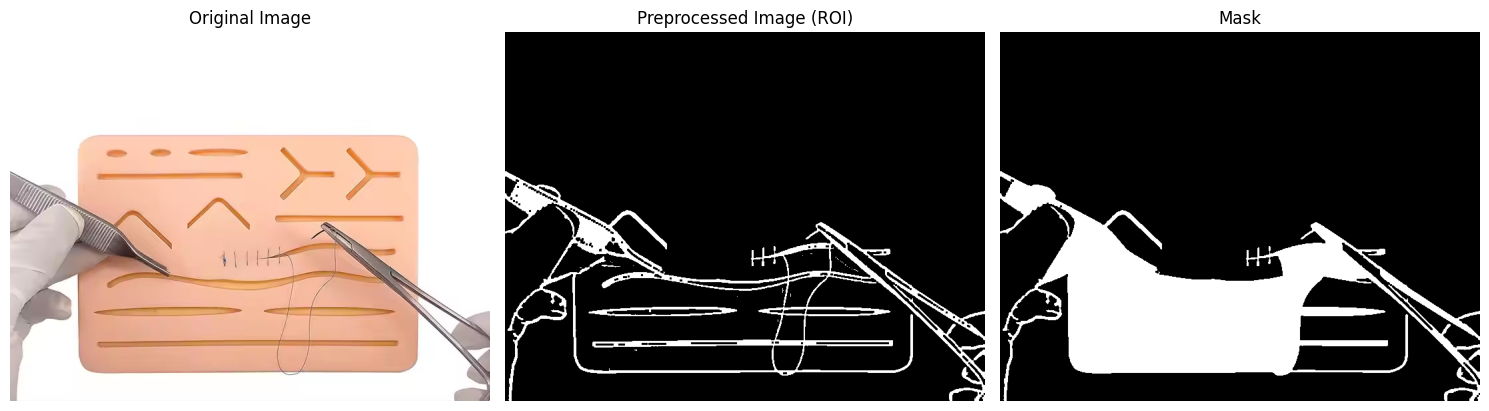

In [2]:
# Load a sample image - replace 'path_to_sample_image.jpg' with your actual image path
image = cv2.imread('sample.png')

# Display the original image (convert from BGR to RGB for proper display)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Process the image
roi, mask = preprocess_image(image)

# Display the preprocessed result
plt.subplot(1, 3, 2)
plt.imshow(roi, cmap='gray')
plt.title('Preprocessed Image (ROI)')
plt.axis('off')

# Display the mask
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
def detect_sutures_traditional(preprocessed_image):
    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(
        preprocessed_image, 
        rho=1,
        theta=np.pi/180,
        threshold=50,
        minLineLength=50,
        maxLineGap=20
    )
    
    suture_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Filter horizontal-ish lines (sutures are generally horizontal)
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
            if 160 <= angle <= 180 or 0 <= angle <= 20:
                suture_lines.append(((x1, y1), (x2, y2)))
    
    return suture_lines

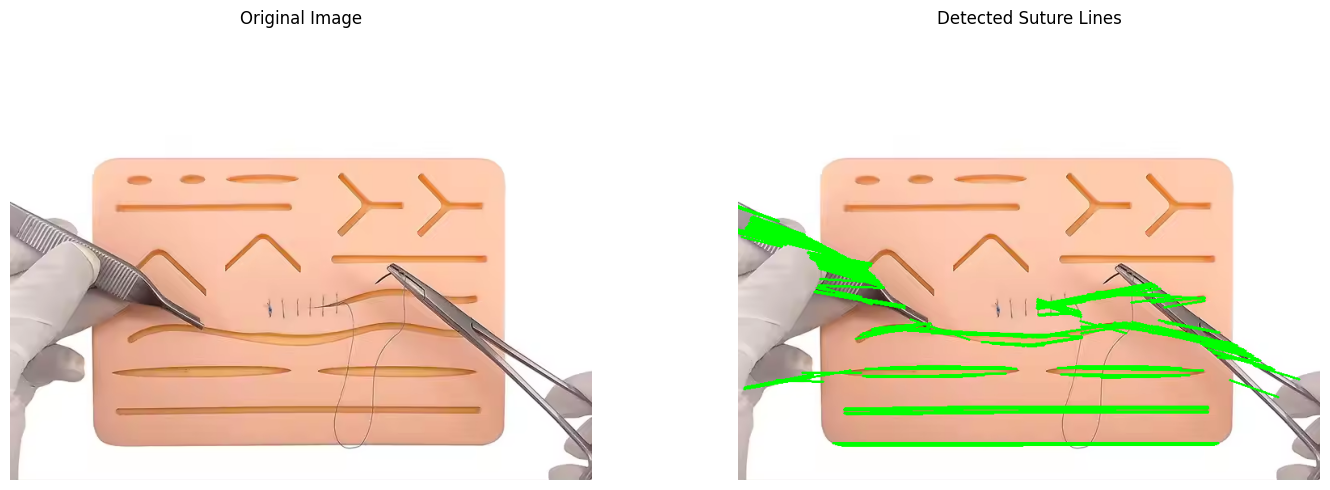

Number of detected suture lines: 137


In [4]:
# Detect suture lines using the traditional method
suture_lines = detect_sutures_traditional(roi)

# Create a copy of the original image to draw lines on
result_image = image.copy()

# Draw detected suture lines
for (x1, y1), (x2, y2) in suture_lines:
    cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Suture Lines')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the number of detected suture lines
print(f"Number of detected suture lines: {len(suture_lines)}")